In [29]:
LOG_PATH = "../log/http.log"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
"""
Reference: http://gauss.ececs.uc.edu/Courses/c6055/pdf/bro_log_vars.pdf
"""

names = ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'id.trans_depth', 'method', 
         'host', 'uri', 'referrer', 'user_agent', 'request_body_len', 'response_body_len', 'status_code',
         'status_msg', 'info_code', 'info_msg', 'filename', 'tags', 'username', 'password', 'proxied',
         'orig_fuids', 'orig_mime_types', 'resp_fuids', 'resp_mime_types']

In [9]:
df = pd.read_csv(LOG_PATH, sep = "\\t", engine = 'python', header = None, names = names)
df.tail()
        

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,id.trans_depth,method,host,uri,...,info_msg,filename,tags,username,password,proxied,orig_fuids,orig_mime_types,resp_fuids,resp_mime_types
2048437,1.332017e+09,CAfsIz2A8Xu5WbUXK8,192.168.202.87,44974,192.168.201.2,80,10,POST,192.168.201.2,/reporting/generateReport.php,...,-,-,(empty),-,-,-,F56aWQ2fj0GIeiEAja,text/plain,F3NLO522BrxzbzGdt5,text/html
2048438,1.332017e+09,CzyNKg1x0ufzurDE6f,192.168.202.87,44975,192.168.201.2,80,1,POST,192.168.201.2,/flagsubmission/getHandleInfo.php,...,-,-,(empty),-,-,-,F7WFOD3BY7HbV8KjX3,text/plain,FuzeP9PNt0qr85Ib2,text/html
2048439,1.332017e+09,CzyNKg1x0ufzurDE6f,192.168.202.87,44975,192.168.201.2,80,2,POST,192.168.201.2,/reporting/generateReport.php,...,-,-,(empty),-,-,-,FFbfyC2hSnNrUOKtSa,text/plain,FqI5OD2cvTjws3VMd,text/html
2048440,1.332017e+09,CzyNKg1x0ufzurDE6f,192.168.202.87,44975,192.168.201.2,80,3,POST,192.168.201.2,/flagsubmission/getHandleInfo.php,...,-,-,(empty),-,-,-,FH8qsC1rQAFZJHfnAc,text/plain,FupI2p4JEuUGrdlK25,text/html
2048441,1.332017e+09,CzyNKg1x0ufzurDE6f,192.168.202.87,44975,192.168.201.2,80,4,POST,192.168.201.2,/reporting/generateReport.php,...,-,-,(empty),-,-,-,FfrmnO2FQmr9ha1HK2,text/plain,FMFblO2dIdqHPs1S29,text/html


In [7]:
# some of the types don't really match up with the documentation
df.dtypes

ts                   float64
uid                   object
id.orig_h             object
id.orig_p              int64
id.resp_h             object
id.resp_p              int64
id.trans_depth         int64
method                object
host                  object
uri                   object
referrer              object
user_agent            object
request_body_len       int64
response_body_len      int64
status_code           object
status_msg            object
info_code             object
info_msg              object
filename              object
tags                  object
username              object
password              object
proxied               object
orig_fuids            object
orig_mime_types       object
resp_fuids            object
resp_mime_types       object
dtype: object

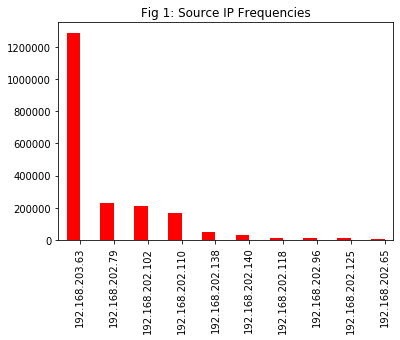

In [57]:
# here we perform some basic visualizations to get a sense of the data
# find unusually high request counts by IP
# can indicate attempted denial of service or host trying to check for open TCP ports
# We implement the denial of service detection, but it seems the port scanning attack is not within the
# scope of this dataset since the destination ports are limited to the following:
# [80, 5357, 5488, 8080, 8000, 1337, 3128, 8834]
df['id.orig_h'].value_counts()[:10].plot.bar(width = 0.4, position = 1, color = 'red', title = 'Fig 1: Source IP Frequencies')


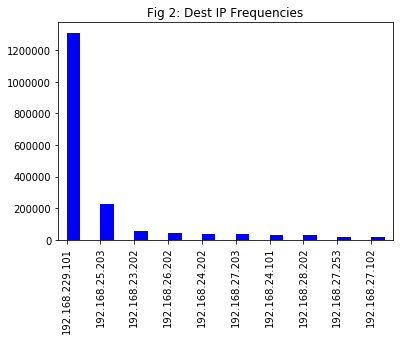

In [59]:
# check for large amount of replies
# could suggest bulk exfiltration of data from servers
df['id.resp_h'].value_counts()[:10].plot.bar(width = 0.4, position = 0, color = 'blue', title = 'Fig 2: Dest IP Frequencies')

In [76]:
# EXPERIMENT 1: Denial of Service
# Nature of attack: Assessing web server's ability to respond to large quantities of requests
# from a single host.
# We can simply output the IPs where the number of requests exceed a certain threshold 
# (in terms of requests per unit time), but we can do better. Let's take a look at the nature of these
# requests. Specifically, we focus first on the source IP which issued the most number of requests observed.
# We assume that the attacks are not distributed in this case - they're all carried out by the same src.

tdf = df[df['id.orig_h'] == '192.168.203.63']
print("Total requests:", tdf.shape) # we check the number of requests being made by this IP address
print("Unique dest ports", tdf['id.resp_p'].unique()) # number of dest ports - here it's just 80 so they're all http requests
print("Timestamp range:", tdf['ts'].max()-tdf['ts'].min()) # timestamp range (in seconds)

print("Avg. Requests per second:", tdf.shape[0]/(tdf['ts'].max()-tdf['ts'].min()))
# We observe that on average, this IP address makes 72 queries a second over the course of ~5 hours.

Total requests: (1289498, 27)
Unique dest ports [80]
Timestamp range: 17822.819999933243
Avg. Requests per second: 72.35095231870321


In [96]:
# SAMPLE IMPLEMENTATION
# Based on experiment 1
# We perform this analysis for all IPs (which send a certain threshold number of packets)
TOTAL_REQ_THRESHOLD = 2000
REQ_PER_SEC_THRESHOLD = 5.0

graylist_1 = []
for src, freq in df['id.orig_h'].value_counts().items():
    if freq > TOTAL_REQ_THRESHOLD:
        tdf = df[df['id.orig_h'] == src]
        if tdf.shape[0]/(tdf['ts'].max() - tdf['ts'].min()) > REQ_PER_SEC_THRESHOLD:
            graylist_1.append({'src_ip': src, 
                             'total_req': tdf.shape[0], 
                             'avg_req_per_sec': tdf.shape[0]/(tdf['ts'].max() - tdf['ts'].min())})
print(graylist_1)

[{'src_ip': '192.168.203.63', 'total_req': 1289498, 'avg_req_per_sec': 72.35095231870321}, {'src_ip': '192.168.202.110', 'total_req': 169126, 'avg_req_per_sec': 5.2968156656409775}]


In [92]:
# EXPERIMENT 2: Port Scanning and known attacks correlated to ports
# Nature of Attack: An attacker may wish to find open TCP ports, or to try their luck with port knocking.
# This analysis is performed by finding which IP addresses make requests to a large number of different ports.
print("unique ports:", df['id.resp_p'].unique())

# Some research shows that a certain number of ports have been known to be used by malicious attackers.
# For instance: port 8834 is commonly used by Nessus web, an application used to discover network
# vulnerabilities. To find IPs which are utilizing this port:
print("IPs targeting port 8834:\n",df[df['id.resp_p'] == 8834]['id.orig_h'].value_counts())
    
# We observe that 192.168.204.45 is targeting this port, and has issued two requests. We may want to add
# this IP to the graylist for further study.

unique ports: [  80 5357 5488 8080 8000 1337 3128 8834]
IPs targeting port 8834:
 192.168.204.45    2
Name: id.orig_h, dtype: int64


In [95]:
# SAMPLE IMPLEMENTATION
# Based on experiment 2
# We perform this same analysis by constructing port filter rules for the following ports
# 1337: Used by the trojan Shadyshell (According to SANS)
# 3128: Used by several threats and trojans including RingZero, Mydoom and Deadhat
# 8834: As above.
# We assume that we have a list of ports which are known to be vulnerable and are "easy targets"
# for attackers, which can be used for running this form of analysis
GRAYLIST_PORTS = [1337, 3128, 8834]

graylist_2 = []
for port in GRAYLIST_PORTS:
    for src, freq in df[df['id.resp_p'] == port]['id.orig_h'].value_counts().items():
        graylist_2.append({'src_ip': src, 'total_req': freq, 'target_port': port})

print(graylist_2)

[{'src_ip': '192.168.202.112', 'total_req': 1, 'target_port': 1337}, {'src_ip': '192.168.202.110', 'total_req': 1, 'target_port': 1337}, {'src_ip': '192.168.202.110', 'total_req': 12593, 'target_port': 3128}, {'src_ip': '192.168.202.138', 'total_req': 7381, 'target_port': 3128}, {'src_ip': '192.168.202.140', 'total_req': 2434, 'target_port': 3128}, {'src_ip': '192.168.202.68', 'total_req': 230, 'target_port': 3128}, {'src_ip': '192.168.202.112', 'total_req': 50, 'target_port': 3128}, {'src_ip': '192.168.202.79', 'total_req': 35, 'target_port': 3128}, {'src_ip': '192.168.202.108', 'total_req': 24, 'target_port': 3128}, {'src_ip': '192.168.204.45', 'total_req': 18, 'target_port': 3128}, {'src_ip': '192.168.202.90', 'total_req': 11, 'target_port': 3128}, {'src_ip': '192.168.202.4', 'total_req': 8, 'target_port': 3128}, {'src_ip': '2001:dbb:c18:202:20c:29ff:fe93:571e', 'total_req': 5, 'target_port': 3128}, {'src_ip': '192.168.203.45', 'total_req': 4, 'target_port': 3128}, {'src_ip': '192.1